In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import bz2

from sklearn.datasets import load_svmlight_file
from sklearn import preprocessing
from sklearn.kernel_ridge import KernelRidge
from sklearn.kernel_approximation import RBFSampler

import matplotlib.pyplot as plt
from copy import copy
from time import time
import sys
import random

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode()

from utils import *
from kernel_approx import *

# Loading the dataset

In [2]:
X_train, y_train = load_svmlight_file('dataset/ijcnn1.bz2')
X_train = X_train.A

X_rescale = preprocessing.scale(X_train)

# Kernel Matrix

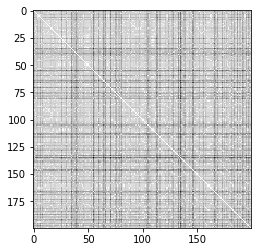

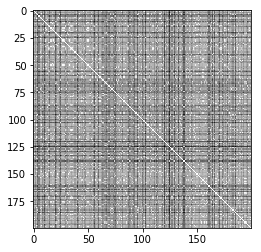

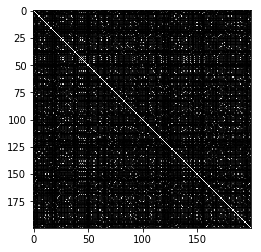

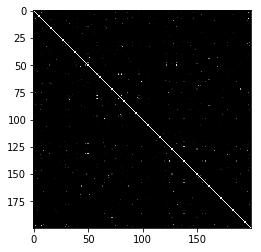

In [3]:
plot_G_sub(X_rescale, 200, RBF_kernel, **{'gamma':1e-3})
plot_G_sub(X_rescale, 200, RBF_kernel, **{'gamma':1e-2})
plot_G_sub(X_rescale, 200, RBF_kernel, **{'gamma':1e-1})
plot_G_sub(X_rescale, 200, RBF_kernel, **{'gamma':1})

Computation time of the entire kernel matrix:

In [4]:
# t0 = time()
# get_gram_matrix(X_rescale, RBF_kernel, **{'gamma': 5e-2})
# print("Total Computation time: %f " % time()-t0)

# Clustering

In [5]:
KM  = KMeans(n_clusters=10, n_jobs=-1)
KM.fit(X_rescale)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
KM.predict(X_train)[:10]

array([4, 9, 7, 0, 3, 1, 2, 5, 6, 8], dtype=int32)

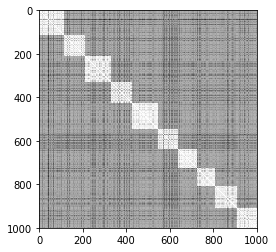

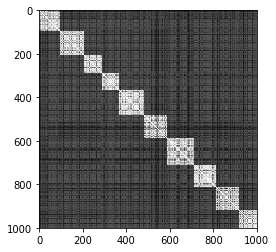

In [7]:
# Gram matrix with clustered points
plot_clust_G_sub(X_train, 1000, RBF_kernel, KM, **{'gamma':5e-2})
plot_clust_G_sub(X_train, 1000, RBF_kernel, KM, **{'gamma':5e-1})

The clustering seems pretty relevant for the Gaussian kernel.

# Kernel Approximation Methods

## Block Kernel Approximation

This first method consists in a clustering step, followed by the exact computation of the Gram matrix corresponding to each cluster. This method is very efficient when the distance between the clusters is relatively large (on the kernel function scale).
For the RBF kernel, we propose two examples. On the first one ($\gamma=5.10^{-1}$), the approximation may hold, and on the second one ($\gamma=5.10^{-2}$) we see that the loss of the non-diagonal terms completely changes the structure of the Gram matrix. The interesting fact is that these two behaviours are observed with only a $\times 10$ multiplication of the scale parameter of the RBF. Due to the exponential nature of the RBF, small shifts in the scale parameter can completely change the quality of the BKA.

In [8]:
X = extract_random_rows(X_rescale, nrows=1000)
C = KM.predict(X)
ind = np.argsort(C)
X, C = X[ind], C[ind]

In [9]:
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-1})
BK_X = BKA(X, C, RBF_kernel, **{'gamma': 5e-1})

100%|██████████| 10/10 [00:00<00:00, 15.31it/s]


Distance bestween G and BKA(G): 0.000003


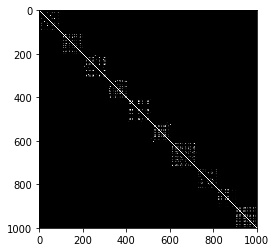

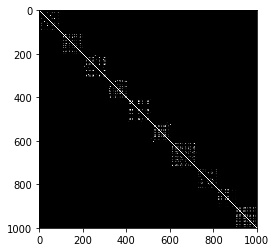

In [10]:
print('Distance bestween G and BKA(G): %f' % compute_distance(G_X, BK_X))
plt.imshow(BK_X, cmap='gray')
plt.show()
plt.imshow(G_X, cmap='gray')
plt.show()

In [11]:
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-2})
BK_X = BKA(X, C, RBF_kernel, **{'gamma': 5e-2})

100%|██████████| 10/10 [00:00<00:00, 15.25it/s]


Distance bestween G and BKA(G) 22852.795806


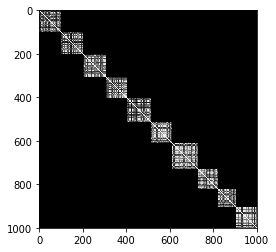

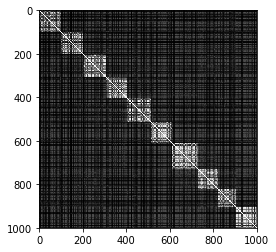

In [12]:
print('Distance bestween G and BKA(G) %f' % compute_distance(G_X, BK_X))
plt.imshow(BK_X, cmap='gray')
plt.show()
plt.imshow(G_X, cmap='gray')
plt.show()

As suggested in the paper, we propose an algorithm to find the optimal number of clusters. (find the number which optimizes the spectral clustering objective).

In [13]:
X = extract_random_rows(X_rescale, nrows=1000)
c0, c1, s = 2, 41, 2
c_opt, obj_list = find_best_BKA(X, RBF_kernel, c_min=c0, c_max=c1, step=s, njobs=-1, **{'gamma':1e-2})

100%|██████████| 40/40 [00:00<00:00, 148.49it/s]


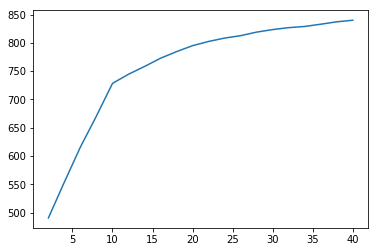

In [14]:
plt.plot(np.arange(c0, c1, s), obj_list)

In our example, the objective function is strictly increasing. However, it would be strictly decreasing if the penalty in the size of the clusters was removed. So the choice of the number of clusters is actually quite arbitrary, depending on the loss function we choose.

## Nyström method

The Nyström method is a different approach to perform kernel approximation.

In [15]:
X = extract_random_rows(X_rescale, nrows=1000)
C = KM.predict(X)
ind = np.argsort(C)
X, C = X[ind], C[ind]

In [16]:
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-2})
C, M = Nystrom(X, 1000, 999, RBF_kernel, return_decompo=True, **{'gamma':5e-2})

Distance bestween G and Nystroem approximation 0.000316


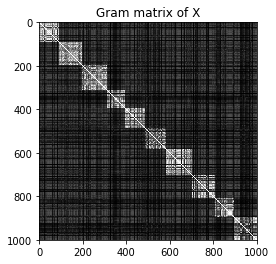

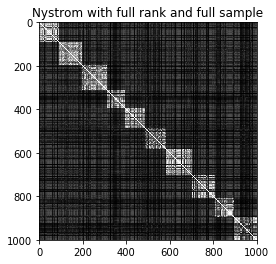

In [17]:
print('Distance bestween G and Nystroem approximation %f' % compute_distance(G_X, C @ M @ C.T))

plt.imshow(G_X, cmap='gray')
plt.title('Gram matrix of X')
plt.show()
plt.imshow(C @ M @ C.T, cmap='gray')
plt.title('Nystrom with full rank and full sample')
plt.show()

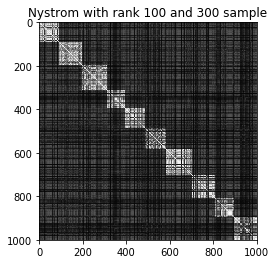

In [18]:
M = Nystrom(X, 300, 100, RBF_kernel, return_decompo=False, **{'gamma':5e-2})
plt.imshow(M, cmap='gray')
plt.title('Nystrom with rank 100 and 300 sample')
plt.show()

In [19]:
print('Distance between the Gram Matrix and Nystrom: %f' % compute_distance(G_X, M))

Distance between the Gram Matrix and Nystrom: 164.324806


## Ensemble Nyström

In [20]:
X = extract_random_rows(X_rescale, nrows=1000)
C = KM.predict(X)
ind = np.argsort(C)
X, C = X[ind], C[ind]

In [21]:
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-2})
G_tilde = EnsembleNystrom(X, 300, 100, RBF_kernel, n_experts=3, **{'gamma':5e-2})

Distance between G and Ensemble Nystroem approximation 101.779177


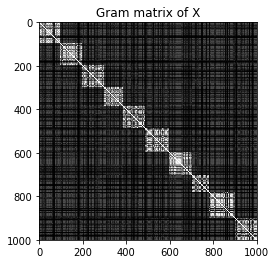

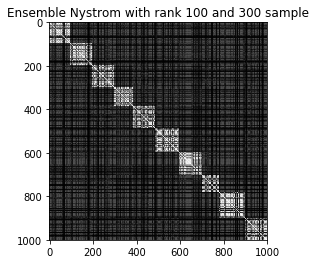

In [22]:
print('Distance between G and Ensemble Nystroem approximation %f' % compute_distance(G_X, G_tilde))

plt.imshow(G_X, cmap='gray')
plt.title('Gram matrix of X')
plt.show()
plt.imshow(G_tilde, cmap='gray')
plt.title('Ensemble Nystrom with rank 100 and 300 sample')
plt.show()

## KMeans Nystrom

In [23]:
X = extract_random_rows(X_rescale, nrows=1000)
C = KM.predict(X)
ind = np.argsort(C)
X, C = X[ind], C[ind]

In [24]:
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-2})
G_tilde = KMEANystrom(X, 300, 100, RBF_kernel, return_decompo=False, **{'gamma':5e-2})

Distance bestween G and KMeans Nystroem approximation 170.685452


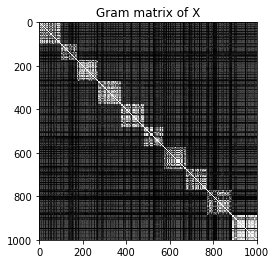

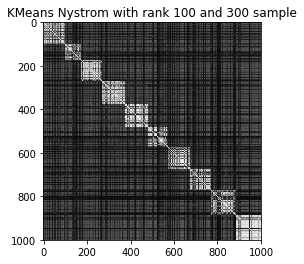

In [25]:
print('Distance bestween G and KMeans Nystroem approximation %f' % compute_distance(G_X, G_tilde))

plt.imshow(G_X, cmap='gray')
plt.title('Gram matrix of X')
plt.show()
plt.imshow(G_tilde, cmap='gray')
plt.title('KMeans Nystrom with rank 100 and 300 sample')
plt.show()

## Random Kitchen Sink 

In [26]:
X = extract_random_rows(X_rescale, nrows=1000)
C = KM.predict(X)
ind = np.argsort(C)
X, C = X[ind], C[ind]

In [27]:
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-2})

rbf_feature = RBFSampler(gamma=5e-2, random_state=1, n_components=500)
X_features = rbf_feature.fit_transform(X)

Distance between G and RKS approximation 1830.989231


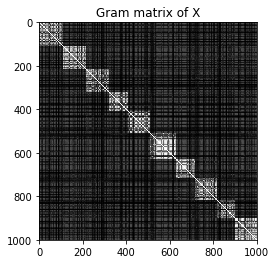

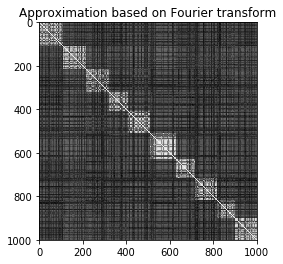

In [28]:
print('Distance between G and RKS approximation %f' % compute_distance(G_X, X_features @ X_features.T))

plt.imshow(G_X, cmap='gray')
plt.title('Gram matrix of X')
plt.show()
plt.imshow(X_features @ X_features.T, cmap='gray')
plt.title('Approximation based on Fourier transform')
plt.show()

## Memory Efficient Kernel Approximation

In [29]:
X = extract_random_rows(X_rescale, nrows=1000)
C = KM.predict(X)
ind = np.argsort(C)
X, C = X[ind], C[ind]
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-2})

In [30]:
res_full = MEKA(X, C, 200, 100, 1, RBF_kernel, **{'gamma': 5e-2})
res = MEKA(X, C, 50, 30, 2, RBF_kernel, **{'gamma': 5e-2})

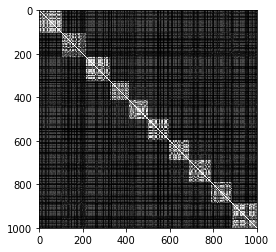

Distance Between Full Sample/Rank MEKA and G 0.611177


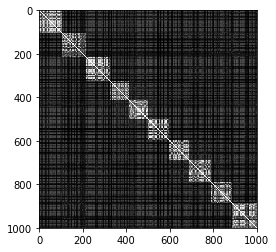

Distance Between MEKA and G (2nd example) 44.288813


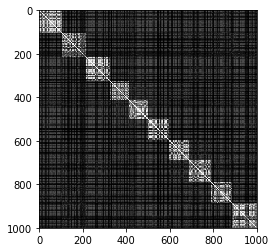

In [31]:
MEKA_X_full = build_G_from_MEKA(*res_full)
MEKA_X = build_G_from_MEKA(*res)

plt.imshow(G_X, cmap='gray')
plt.show()

print('Distance Between Full Sample/Rank MEKA and G %f' %compute_distance(G_X, MEKA_X_full))
plt.imshow(MEKA_X_full, cmap='gray')
plt.show()

print('Distance Between MEKA and G (2nd example) %f' %compute_distance(G_X, MEKA_X))
plt.imshow(MEKA_X*(MEKA_X>0), cmap='gray')
plt.show()

In [32]:
MEKA_X.min()

-0.15439429333489466

# Experimental results

In [33]:
k=25
gamma=1
c=10

In [34]:
X = extract_random_rows(X_rescale, nrows=10000)

KM  = KMeans(n_clusters=c, n_jobs=-1)
start = time()
KM.fit(X_rescale)
C = KM.predict(X)
TC = time() - start
ind = np.argsort(C)

X, C = X[ind], C[ind]

start = time()
G_X = get_gram_matrix(X, RBF_kernel, **{'gamma': 5e-2})
time() - start

641.3109340667725

In [35]:
random.seed(37)

res = MEKA(X, C, 2*k, k, 2, RBF_kernel, **{'gamma': gamma})
MEKA_X = build_G_from_MEKA(*res)
print('Distance Between MEKA and G %f' % relative_error(G_X, MEKA_X))

res = MEKA(X, C, 2*k, k, 2, RBF_kernel, centroids=KM.cluster_centers_, epsilon=0.1, **{'gamma': gamma})
MEKA_X = build_G_from_MEKA(*res)
print('Distance Between MEKA (threshold inter-cluster) and G %f' % relative_error(G_X, MEKA_X))

C_, M = Nystrom(X, 2*k, k, RBF_kernel, return_decompo=True, **{'gamma':gamma})
print('Distance between G and Nystroem approximation %f' % relative_error(G_X, C_ @ M @ C_.T))

G_KN = KMEANystrom(X, 2*k, k, RBF_kernel, return_decompo=False, **{'gamma':gamma})
print('Distance bestween G and KMeans Nystroem approximation %f' % relative_error(G_X, G_KN))

G_EN = EnsembleNystrom(X, 2*k, k, RBF_kernel, n_experts=3, **{'gamma':gamma})
print('Distance between G and Ensemble Nystroem approximation %f' % relative_error(G_X, G_EN))

rbf_feature = RBFSampler(gamma=gamma, random_state=1, n_components=k)
X_features = rbf_feature.fit_transform(X)
print('Distance between G and RKS approximation %f' % relative_error(G_X, X_features @ X_features.T))

Distance Between MEKA and G 0.966354
Distance Between MEKA (threshold inter-cluster) and G 0.967349
Distance between G and Nystroem approximation 0.990494
Distance bestween G and KMeans Nystroem approximation 0.983562
Distance between G and Ensemble Nystroem approximation 0.989767
Distance between G and RKS approximation 1.295838


In [36]:
def testMethods(X, G, kernel, rank_m=10, rank_M=150, step=15, threshold=-1, **param):
    Nystrom_, KNystrom, ENystrom, RKS, MEK = [], [], [], [], []
    
    for k in range(rank_m, rank_M+1, step):
        print(k)
        N, K, E, R, M, = [], [], [], [], []
        
        start = time()
        A, B = Nystrom(X, 2*k, k, kernel, return_decompo=True, **param)
        GN = A @ B @ A.T
        N.append(time() - start)
        N.extend([A.shape[0]*A.shape[1]+B.shape[0]*B.shape[1], relative_error(G, GN)])
        Nystrom_.append(N)
        
        start = time()
        A, B = KMEANystrom(X, 2*k, k, kernel, return_decompo=True, **param)  
        KN = A @ B @ A.T
        K.append(time() - start)
        K.extend([A.shape[0]*A.shape[1]+B.shape[0]*B.shape[1], relative_error(G, KN)])
        KNystrom.append(K)
        
        start = time()
        EN = EnsembleNystrom(X, 2*k, k, kernel, n_experts=3, **param)
        E.append(time() - start)
        E.extend([3*((2*k)**2+X.shape[0]*2*k), relative_error(G, EN)])
        ENystrom.append(E)
        
        start = time()
        rbf_feature = RBFSampler(gamma=gamma, random_state=1, n_components=k)
        X_features = rbf_feature.fit_transform(X)
        RN = X_features @ X_features.T
        R.append(time() - start)
        R.extend([X_features.shape[0]*X_features.shape[1], relative_error(G, RN)])
        RKS.append(R)
        
        if threshold <=0:
            start = time()
            res = MEKA(X, C, 2*k, k, 2, RBF_kernel, **param)
            MEKA_X = build_G_from_MEKA(*res)
            M.append(time() - start + TC)
            M.extend([(c*k)**2+k*X.shape[0], relative_error(G, MEKA_X)])
            MEK.append(M)
        else:
            start = time()
            res = MEKA(X, C, 2*k, k, 2, RBF_kernel, epsilon=threshold, centroids=KM.cluster_centers_,
                       **param)
            MEKA_X = build_G_from_MEKA(*res)
            M.append(time() - start + TC)
            M.extend([(c*k)**2+k*X.shape[0], relative_error(G, MEKA_X)])
            MEK.append(M)
        
    return( Nystrom_, KNystrom, ENystrom, RKS, MEK )

In [42]:
random.seed(37)

testResults_G = testMethods(X, G_X, RBF_kernel, **{'gamma':gamma})
testResults_GT = testMethods(X, G_X, RBF_kernel, threshold=0.5, **{'gamma':gamma})

testResults_L = testMethods(X, G_X, Laplacian_kernel, **{'gamma':gamma})
testResults_LT = testMethods(X, G_X, Laplacian_kernel, threshold=0.5, **{'gamma':gamma})

10
25
40
55
70
85
100
115
130
145
10
25
40
55
70
85
100
115
130
145
10
25
40
55
70
85
100
115
130
145
10
25
40
55
70
85
100
115
130
145


In [43]:
Res_dic = {
    'Gaussian': testResults_G,
    'GaussianThreshold': testResults_GT,
    'Laplacian': testResults_L,
    'LaplacianThreshold': testResults_LT
}

In [56]:
ToBeVisualized = 'GaussianThreshold'

In [60]:
testResults=Res_dic[ToBeVisualized]

trace0 = go.Scatter(
    x = [l_[0] for l_ in testResults[0]],
    y = [l_[2] for l_ in testResults[0]],
    name = 'Nystrom',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
)

trace1 = go.Scatter(
    x = [l_[0] for l_ in testResults[1]],
    y = [l_[2] for l_ in testResults[1]],
    name = 'KNystrom',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,)
)
trace2 = go.Scatter(
    x = [l_[0] for l_ in testResults[2]],
    y = [l_[2] for l_ in testResults[2]],
    name = 'ENystrom',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4,
        dash = 'dash') # dash options include 'dash', 'dot', and 'dashdot'
)
trace3 = go.Scatter(
    x = [l_[0] for l_ in testResults[3]],
    y = [l_[2] for l_ in testResults[3]],
    name = 'RKS',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,
        dash = 'dash')
)
trace4 = go.Scatter(
    x = [l_[0] for l_ in testResults[4]],
    y = [l_[2] for l_ in testResults[4]],
    name = 'MEKA',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4,
        dash = 'dot')
)

data = [trace0, trace1, trace2, trace4]

# Edit the layout
layout = dict(title = 'Error approximation vs. Computation time (%s Kernel)' % ToBeVisualized.split('Threshold')[0],
              xaxis = dict(title = 'Computation time (s)'),
              yaxis = dict(title = 'Error approximation'),
              )

fig = dict(data=data, layout=layout)
iplot(fig)

In [61]:
trace0 = go.Scatter(
    x = [l_[1] for l_ in testResults[0]],
    y = [l_[2] for l_ in testResults[0]],
    name = 'Nystrom',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
)

trace1 = go.Scatter(
    x = [l_[1] for l_ in testResults[1]],
    y = [l_[2] for l_ in testResults[1]],
    name = 'KNystrom',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,)
)
trace2 = go.Scatter(
    x = [l_[1] for l_ in testResults[2]],
    y = [l_[2] for l_ in testResults[2]],
    name = 'ENystrom',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4,
        dash = 'dash') # dash options include 'dash', 'dot', and 'dashdot'
)
trace3 = go.Scatter(
    x = [l_[1] for l_ in testResults[3]],
    y = [l_[2] for l_ in testResults[3]],
    name = 'RKS',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,
        dash = 'dash')
)
trace4 = go.Scatter(
    x = [l_[1] for l_ in testResults[4]],
    y = [l_[2] for l_ in testResults[4]],
    name = 'MEKA',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4,
        dash = 'dot')
)

data = [trace0, trace1, trace2, trace4]

# Edit the layout
layout = dict(title = 'Error approximation vs. Memory size (%s Kernel)' % ToBeVisualized.split('Threshold')[0],
              xaxis = dict(title = 'Memory size'),
              yaxis = dict(title = 'Error approximation'),
              )

fig = dict(data=data, layout=layout)
iplot(fig)